# AttCAT & DR similarity calculation

In [1]:
import torch
import pickle
import glob
import math
import numpy as np
import pandas as pd
import tqdm as tqdm
from scipy.special import softmax
import scipy.stats as stats
from sklearn.metrics.pairwise import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from transformers import AutoTokenizer,BertTokenizer,BertForMaskedLM
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = 'base'
nlayer = 12 if config == 'base' else 24
nsamples = 50000 if config == 'base' else 100000



In [2]:
model = BertForMaskedLM.from_pretrained('bert-'+config+'-uncased', output_hidden_states=True).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-'+config+'-uncased')
# turn on eval mode
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

## 1. OCCTMP 
* distance between absolute DR-score and absolute impact score
* template: [MASK] is a [profession] in this area.
* densray score of the sentence with layers store in the map


In [3]:
with open('OCCTMP_mask_AttCAT.txt', 'rb') as file:
    Att_cat = pickle.load(file)
print(len(Att_cat))
for (k,v) in Att_cat[0].items():
    print(k,type(v))

320
AttCAT <class 'numpy.ndarray'>
raws <class 'numpy.ndarray'>
CAT_h <class 'numpy.ndarray'>
CAT <class 'numpy.ndarray'>
lines <class 'str'>
tokens <class 'list'>
mask <class 'torch.Tensor'>


In [5]:
with open('OCCTMP_mask_dict3.txt', 'rb') as file:
    OCCTMP_mask_list = pickle.load(file)
OCCTMP_mask_list[0].keys()

dict_keys(['sentence', 'tokens', 'mat'])

In [6]:
AttCATscore_list = [Att_cat[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(Att_cat))] # a list of 320 (7,) arrays
DRscore_list = [OCCTMP_mask_list[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(OCCTMP_mask_list))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)

320

In [7]:
import sklearn
sklearn.metrics.pairwise.distance_metrics()

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, *, sum_over_features='deprecated')>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, *, sum_over_features='deprecated')>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None, *, sum_over_features='deprecated')>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

In [15]:
from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(Att_cat)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.04753398055076963 181
mean : 0.47381834543342516
min absolute euclidean distance & index: 0.3083309284696345 181
mean : 0.9549444206695202
min absolute manhattan distance & index: 0.3083309284696345 181
mean : 2.140854912967522
min absolute haversine distance & index: 0.3083309284696345 181
mean : 0.5330378144346144
mean normalized euclidean distance: 0.3508661238839868
mean normalized manhattan distance: 0.2883632280526105


In [68]:
i=181
print(OCCTMP_mask_list[i]["sentence"])
print("Att_cat score",Att_cat[i]["AttCAT"].sum(axis = 0))
print("DR score",OCCTMP_mask_list[i]["mat"].sum(axis = 0))
print("normalized absolute impact AttCAT score:", ip_abs_list[i][0])
print("normalized absolute DR bias score:", DR_abs_list[i][0])

[MASK] is the marshal in this area
Att_cat score [-0.18845756 -0.07910486 -0.06277336 -0.30398196 -0.10985854  0.12285568
  0.15158454]
DR score [1.43382902 0.8506161  1.58981916 4.01141924 1.00656727 2.5501892
 1.47853751]
normalized absolute impact AttCAT score: [0.43434513 0.1823159  0.14467609 0.7005985  0.25319505 0.28315005
 0.3493625 ]
normalized absolute DR bias score: [0.25710423 0.15252655 0.2850753  0.71929975 0.18049063 0.45728216
 0.26512105]


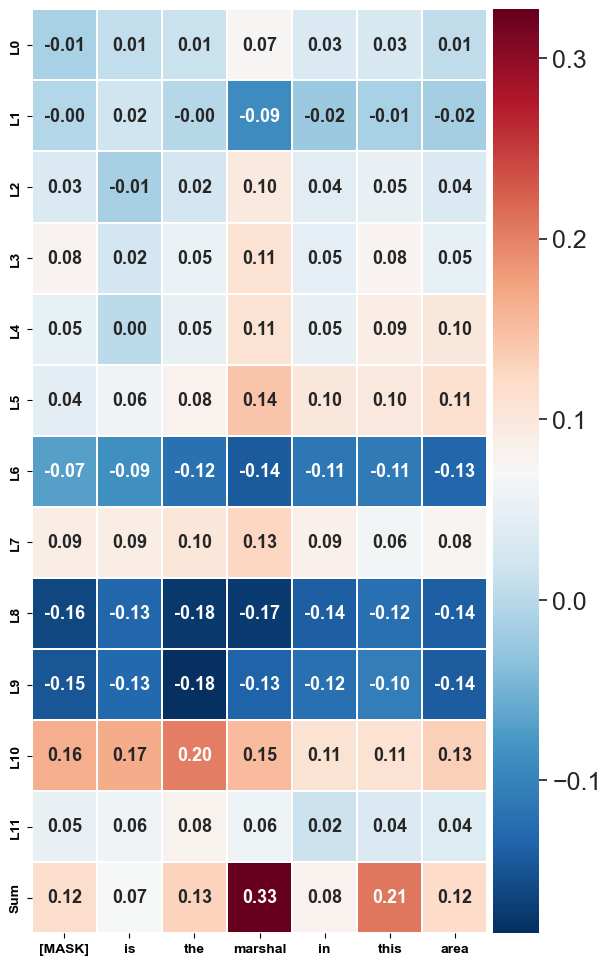

In [69]:
sent = OCCTMP_mask_list[i]["sentence"]
prof_str = Att_cat[i]["lines"].strip().split()[-4]
tokens =  [tokenizer.convert_ids_to_tokens(i) for i in OCCTMP_mask_list[i]["tokens"]]
DRmat = OCCTMP_mask_list[i]["mat"]

    

    # summing all layers
DRsum = DRmat.sum(axis = 0)
    #Attsum=Attmat.sum(axis = 0)

DR_add = np.vstack([DRmat, DRsum])
    #Att_add = np.vstack([Attmat, Attsum])
    
    #DR_add = DR_add * Att_add
    # normalize
norm1_DR = DR_add / np.linalg.norm(DR_add)
    #norm1_DR = DR_add
    #norm1_DR =DRmat
    # plotting heatmap
yticklabels=['L'+str(i) for i in range(12)]
yticklabels.append('Sum')

fig, ax = plt.subplots(figsize=(len(tokens)-2, 12))
sns.set(font_scale=1)
sns.heatmap(norm1_DR, xticklabels = tokens[1:-1], yticklabels=yticklabels,cmap="RdBu_r",
                    linewidths=0.1, annot=True, annot_kws={"fontsize":13, 'fontweight':'heavy'}, cbar_kws={"values":None, "location":'right',
                                                                "pad":0.01}, fmt='.2f', cbar = True)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10, fontweight = 'heavy')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10, fontweight = 'heavy')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
    


#plt.savefig('./AttDR/{}.png'.format(prof_str), format='png', transparent=True, dpi=360, bbox_inches='tight')
        # 显示热力图
plt.show()

    # 关闭图形，以便下一个循环重新创建

## 2. ADJTMP 
* distance between absolute DR-score and absolute impact score(absolute value)
* template: [MASK] is a [adj] person.
### 2.1 intelligence vs appearance

In [3]:
adj_m = "precocious, resourceful, inquisitive, genius, inventive, astute, adaptable, reflective,discerning, intuitive, inquiring, judicious, analytical, apt, venerable, imaginative,shrewd, thoughtful, wise, smart, ingenious, clever, brilliant, logical, intelligent".lower().replace(" ", "").split(',')
adj_f = "alluring, voluptuous, blushing, homely, plump, sensual, gorgeous, slim, bald,athletic, fashionable, stout, ugly, muscular, slender, feeble, handsome, healthy,attractive, fat, weak, thin, pretty, beautiful, strong".lower().replace(" ", "").split(',')

In [18]:
with open('./ADJ/ADJTMP_male_DR.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./ADJ/ADJTMP_male_AttCAT.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)


from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.13960404444171548 5
mean : 0.3294620789498897
min absolute euclidean distance & index: 0.5284014543223461 5
mean : 0.7950246867091009
min absolute manhattan distance & index: 0.5284014543223461 5
mean : 1.7317410697894493
min absolute haversine distance & index: 0.5284014543223461 5
mean : 0.4506796833876647
mean normalized euclidean distance: 0.3060487618648153
mean normalized manhattan distance: 0.2561679427127527


In [25]:
ADJTMP_male_DR[5]['sentence']

'[MASK] is a astute person.'

In [19]:
with open('./ADJ/ADJTMP_female_DR.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./ADJ/ADJTMP_female_AttCAT.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)


from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.1994189626867643 20
mean : 0.4180381031075148
min absolute euclidean distance & index: 0.6315361583854027 20
mean : 0.9014427713918418
min absolute manhattan distance & index: 0.6315361583854027 20
mean : 1.835707510126194
min absolute haversine distance & index: 0.6315361583854027 20
mean : 0.6663189395840534
mean normalized euclidean distance: 0.36212064491946216
mean normalized manhattan distance: 0.2959542071816245


In [27]:
ADJTMP_male_DR[20]['sentence']

'[MASK] is a weak person.'

### 2.2: strength vs weakness

In [ ]:
        
x_words = "powerful, strong, confident, dominant, potent, commanding, assertive, loud, bold, successful, noisy, dynamic".lower().replace(" ", "").split(',')
y_words = "weak, timid, vulnerable, weakness, wispy, yielding, failure, shy, lose, fragile, faintish, pavid".lower().replace(" ", "").split(',')
y_words


In [20]:
with open('./ADJ/ADJTMP2_male_DR.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./ADJ/ADJTMP2_male_AttCAT.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)



from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.07818840642723579 8
mean : 0.36439042821683926
min absolute euclidean distance & index: 0.3954450746212788 8
mean : 0.8320550775984296
min absolute manhattan distance & index: 0.3954450746212788 8
mean : 1.6731378025219736
min absolute haversine distance & index: 0.3954450746212788 8
mean : 0.5500014459996677
mean normalized euclidean distance: 0.336785609481205
mean normalized manhattan distance: 0.27455327282216174


In [29]:
ADJTMP_male_DR[8]['sentence']

'[MASK] is a bold person.'

In [21]:
with open('./ADJ/ADJTMP2_female_DR.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./ADJ/ADJTMP2_female_AttCAT.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)



from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.15713080815970337 5
mean : 0.362549041219256
min absolute euclidean distance & index: 0.5605904018561554 5
mean : 0.8357075814379912
min absolute manhattan distance & index: 0.5605904018561554 5
mean : 1.775793317121103
min absolute haversine distance & index: 0.5605904018561554 5
mean : 0.606155936820559
mean normalized euclidean distance: 0.3307882093423025
mean normalized manhattan distance: 0.27763385297539794


In [35]:
ADJTMP_male_DR[5]['sentence']

'[MASK] is a yielding person.'

## NOUNTMP

In [ ]:
n_m = 'math, algebra, geometry, calculus, equations, computation, numbers, addition, science, technology, physics, chemistry, Einstein, NASA, experiment, astronomy'.lower().replace(" ", "").split(',')
n_f = 'poetry, art, dance, literature, novel, symphony, drama, sculpture'.lower().replace(" ", "").split(',')

In [22]:
with open('./N/NTMP_male_DR.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./N/NTMP_male_AttCAT.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)



from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.1461215464318637 7
mean : 0.39288390306634746
min absolute euclidean distance & index: 0.5405951408781305 7
mean : 0.8728354125524372
min absolute manhattan distance & index: 0.5405951408781305 7
mean : 1.7710037091055486
min absolute haversine distance & index: 0.5405951408781305 7
mean : 0.5952375012869069
mean normalized euclidean distance: 0.3563335650308531
mean normalized manhattan distance: 0.2951672848509248


In [37]:
ADJTMP_male_DR[7]['sentence']

'[MASK] is good at addition.'

In [23]:
with open('./N/NTMP_female_DR.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./N/NTMP_female_AttCAT.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)



from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.20298639290461462 6
mean : 0.37198535314724024
min absolute euclidean distance & index: 0.6371599372550363 6
mean : 0.8527650177986115
min absolute manhattan distance & index: 0.6371599372550363 6
mean : 1.7058299833148047
min absolute haversine distance & index: 0.6371599372550363 6
mean : 0.5941101164927508
mean normalized euclidean distance: 0.3481398606836689
mean normalized manhattan distance: 0.28430499721913416


In [39]:
ADJTMP_male_DR[6]['sentence']

'[MASK] is good at drama.'

## CSP dataset

In [4]:
with open('./CSP_DR_scores.txt', 'rb') as file:
    ADJTMP_male_DR = pickle.load(file)
with open('./AttCAT_mask_CSP.txt', 'rb') as file:
    ADJTMP_male_AttCAT = pickle.load(file)


AttCATscore_list = [ADJTMP_male_AttCAT[i]["AttCAT"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_AttCAT))] # a list of 320 (7,) arrays
DRscore_list = [ADJTMP_male_DR[i]["mat"].sum(axis = 0).reshape(1,-1) for i in range(len(ADJTMP_male_DR))]

ip_abs_list = [abs(AttCATscore_list[i]/np.linalg.norm(AttCATscore_list[i])) for i in range(len(AttCATscore_list))]
DR_abs_list = [abs(DRscore_list[i]/np.linalg.norm(DRscore_list[i])) for i in range(len(DRscore_list))]
len(AttCATscore_list)



from sklearn.metrics.pairwise import *
cos_dis=[]
eucl_dis = []
manh_dis = []
have_dis= []
eucl_norm = []
manh_norm = []

for i in range(len(ADJTMP_male_DR)):
    cos_dis.append(cosine_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0])
    euc = euclidean_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    eucl_dis.append(euc)
    eucl_norm.append(euc/np.sqrt(ip_abs_list[i][0].shape[0]))
    mah = manhattan_distances(ip_abs_list[i],DR_abs_list[i]).tolist()[0][0]
    manh_dis.append(mah)
    manh_norm.append(mah/ip_abs_list[i][0].shape[0])
    #have_dis.append(haversine_distances(ip_abs_list[i][0][[0,3]].reshape(1,-1),DR_abs_list[i][0][[0,3]].reshape(1,-1)).tolist()[0][0])
    
    
print("min absolute cosine distance & index:", min(cos_dis),np.argmin(cos_dis))
print("mean :",np.mean(cos_dis))
print("min absolute euclidean distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(eucl_dis))
print("min absolute manhattan distance & index:", min(eucl_dis),np.argmin(eucl_dis))
print("mean :",np.mean(manh_dis))
#print("min absolute haversine distance & index:", min(eucl_dis),np.argmin(eucl_dis))
#print("mean :",np.mean(have_dis))
print("mean normalized euclidean distance:",np.mean(eucl_norm))
print("mean normalized manhattan distance:",np.mean(manh_norm))

min absolute cosine distance & index: 0.14999297600145955 195
mean : 0.5776797314164592
min absolute euclidean distance & index: 0.5477097274696098 195
mean : 1.0623681740892243
min absolute manhattan distance & index: 0.5477097274696098 195
mean : 2.8149586896236065
mean normalized euclidean distance: 0.3053661825754547
mean normalized manhattan distance: 0.22938829059902463


In [5]:
ADJTMP_male_DR[195]['sentence']

'The blacks hated the whites at [MASK]'